In [55]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
import cv2
from sklearn.neighbors import NearestNeighbors
np.set_printoptions(threshold=sys.maxsize)

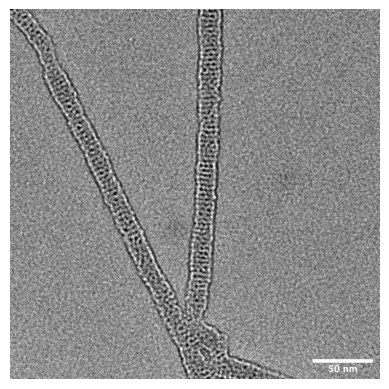

In [3]:
# Open the TIFF image

img = cv2.imread('nanowire.tif', cv2.IMREAD_GRAYSCALE)
img_array = np.array(img) 

# Display the image using M,atplotlib
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off') # Optional: hide axes

plt.show()


In [4]:
# Cut scale bar from the image and make it binary
def cut_scale_bar(img):
    '''
    Returns a row of binary number representing scale bar
    '''
    scale_bar = img[1940:1950, 1600:-1]
    _,thresh1 = cv2.threshold(scale_bar,254,255,cv2.THRESH_BINARY)
    plt.imshow(thresh1,cmap="gray")
    plt.show()

    return thresh1[1].tolist()


# Calculate the translation between scale bar & pixels
def dist_btw_scale_bar(lst, value):
    '''
    Args:
        lst: a row in the image that cuts thru the scale bar
        value: usually = 255 if white

    Returns:
        length of distance between scale bar in pixels
    '''
    # find first occurance of white scale bar
    j = lst.index(value)
    # find last occurance of white scale bar
    lst.reverse()
    i = lst.index(value)
    return (len(lst) - i - 1) - j

def translate_pixel_to_nm(length_pixel, scale_bar_length):
    '''
    Args:
        length_pixel: from `dist_btw_scale_bar`, the number of pixels between scale bar
        scale_bar_length: actual scale bar length from SEM

    Returns:
        physical length of each pixel in nanometer  
    '''
    return scale_bar_length / length_pixel 

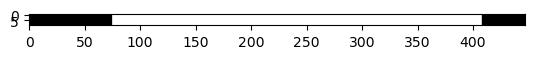

0.15060240963855423


In [5]:
thresh_row = cut_scale_bar(img)
length_pixel = dist_btw_scale_bar(thresh_row,255)
pixel_to_nm = translate_pixel_to_nm(length_pixel, 50)
print(pixel_to_nm)

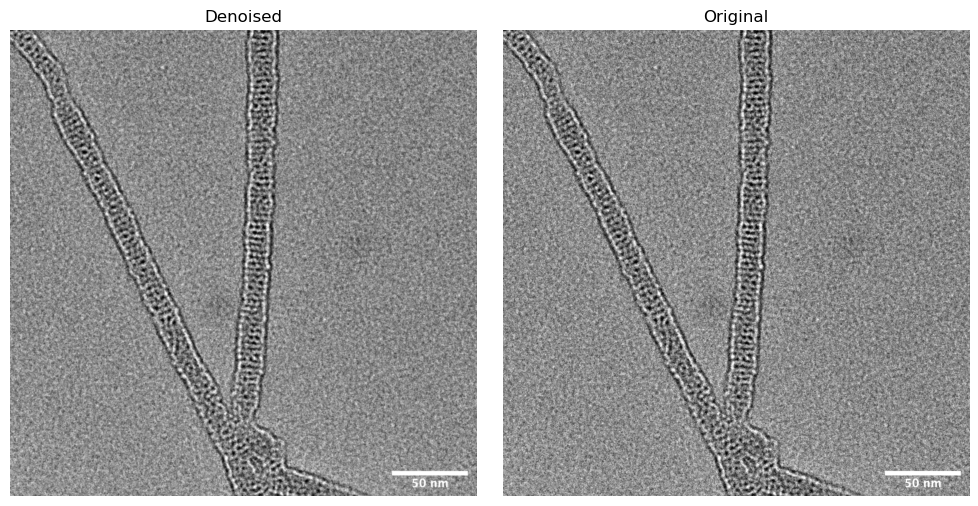

In [6]:
img_blur = cv2.GaussianBlur(img, (5,5), 1.0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img_blur,cmap='gray')
ax1.set_title('Denoised')
ax1.axis('off') # Optional: hides the axis ticks

ax2.imshow(img,cmap='gray')
ax2.set_title('Original')
ax2.axis('off') # Optional: hides the axis ticks

plt.tight_layout()

plt.show()

In [40]:
img_blur[1,950:1200]
line_grad = np.gradient(img_blur[700,950:1200])
line_grad.argmax()

np.int64(160)

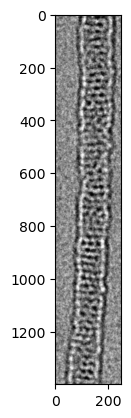

In [42]:
plt.imshow(img_blur[0:1400,950:1200],cmap="gray")
#plt.plot(line_grad, color='red', linestyle='--', linewidth=2, label='Overlay Line')
plt.show()

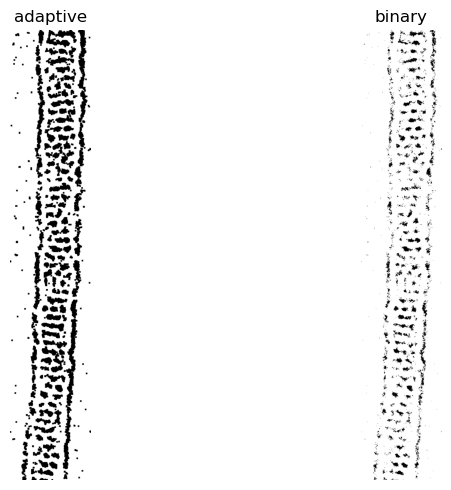

In [213]:
cropped_image = img[0:1400, 950:1200]

# binary thresholding, change threshold if needed
ret,thresh1 = cv2.threshold(cropped_image,50,255,cv2.THRESH_BINARY)


# adaptive thresholding
kernel = np.ones((5, 5), np.uint8) 
ret3,binary_img = cv2.threshold(cropped_image,30,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img_adaptive = cv2.erode(thresh1, kernel, iterations=1) 



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_adaptive,cmap='gray')
ax1.set_title('adaptive')
ax1.axis('off') # Optional: hides the axis ticks

ax2.imshow(thresh1,cmap='gray')
ax2.set_title('binary')
ax2.axis('off') # Optional: hides the axis ticks

plt.tight_layout()
plt.show()

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255 255
  255 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0
    0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255
  255 255 255 255 255 255 255 255 255 

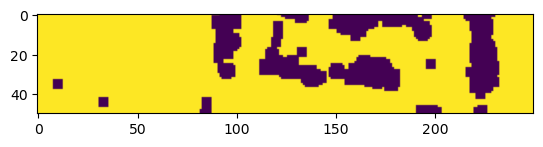

In [77]:
plt.imshow(img_adaptive[10:60])
img_cut = img_adaptive[10:60]
x_list = []
y_list = []
#print(img_cut)
for i in range(len(img_cut)-1):
    for j in range(len(img_cut[0])-1):
            # print((i,j))
        pass

print(img_cut)

In [187]:
from skimage.measure import label

# binary_image: 2D numpy array
# 0 = dot, 255 = background

# Create foreground mask
foreground = (thresh1 == 0)

# Label connected components (8-connectivity)
labeled = label(foreground, connectivity=1)

clusters = {}

for label_id in range(1, labeled.max() + 1):
    coords = np.column_stack(np.where(labeled == label_id))
    clusters[label_id] = coords.tolist()


In [188]:
print(f"Number of dots: {len(coords)}")
print(f"Number of clusters: {len(clusters)}")





Number of dots: 1
Number of clusters: 2381


In [189]:
MIN_PIXELS = 10

filtered_clusters = {
    label: coords
    for label, coords in clusters.items()
    if len(coords) >= MIN_PIXELS
}


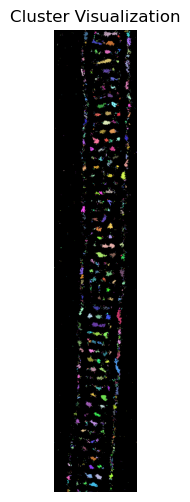

In [190]:

import numpy as np
import matplotlib.pyplot as plt

# Image size (same as original image)
h, w = thresh1.shape

# RGB canvas
vis = np.zeros((h, w, 3), dtype=np.uint8)

rng = np.random.default_rng(0)

for label, coords in clusters.items():
    color = rng.integers(50, 255, size=3)
    for r, c in coords:
        vis[r, c] = color

plt.figure(figsize=(6, 6))
plt.imshow(vis)
plt.title("Cluster Visualization")
plt.axis("off")
plt.show()

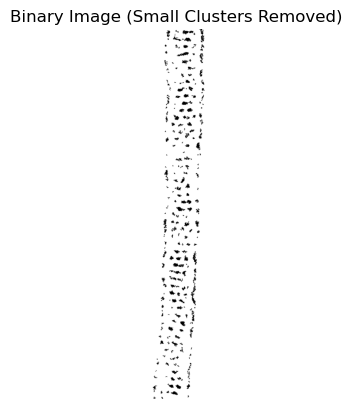

In [191]:
cleaned = np.full(thresh1.shape, 255, dtype=np.uint8)

for coords in filtered_clusters.values():
    for r, c in coords:
        cleaned[r, c] = 0

plt.imshow(cleaned, cmap="gray")
plt.title("Binary Image (Small Clusters Removed)")
plt.axis("off")
plt.show()

In [195]:
import numpy as np

all_centroids = []

for label, coords in filtered_clusters.items():
    coords = np.array(coords)  # shape (N, 2)
    centroid = coords.mean(axis=0)  # (row, col) → (y, x)
    # convert to (x, y) order if needed
    all_centroids.append([centroid[1], centroid[0]])  # [x, y]

# Convert to 2D NumPy array
all_centroids_array = np.array(all_centroids)  # shape: (num_clusters, 2)


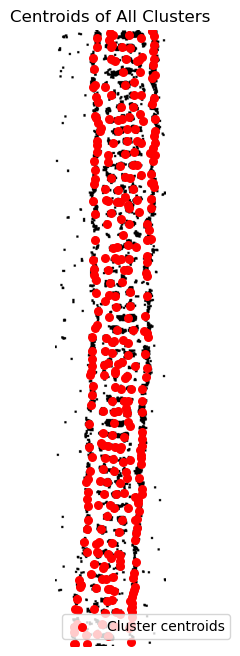

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(img_adaptive, cmap='gray')  # original image as background

# scatter all centroids
plt.scatter(all_centroids_array[:, 0], all_centroids_array[:, 1],
            c='red', s=30, label='Cluster centroids')

plt.title("Centroids of All Clusters")
plt.axis('off')
plt.legend()
plt.show()


In [204]:
all_centroids_array

array([[ 219.52173913,    2.65217391],
       [ 223.46666667,   12.59047619],
       [ 124.73684211,    6.52631579],
       [  95.46448087,   16.61202186],
       [ 167.54848485,   11.34242424],
       [ 131.13043478,   10.17391304],
       [ 194.10344828,   18.27586207],
       [ 120.7       ,   21.6       ],
       [ 225.20967742,   34.02688172],
       [ 127.26347305,   37.56287425],
       [ 129.        ,   32.75      ],
       [ 169.02978723,   39.74893617],
       [  94.95238095,   37.61904762],
       [ 150.66666667,   38.27777778],
       [ 221.26923077,   46.38461538],
       [ 196.2972973 ,   60.02702703],
       [ 224.875     ,   65.1125    ],
       [  85.33333333,   62.58333333],
       [ 126.28070175,   64.54385965],
       [ 160.66433566,   65.70629371],
       [ 191.        ,   68.        ],
       [ 136.21052632,   70.10526316],
       [ 186.4       ,   70.4       ],
       [ 221.68085106,   78.19148936],
       [  87.62      ,   87.96      ],
       [ 153.28343949,   

In [207]:
mean = np.mean(all_centroids_array, axis=0)        # mean of x and y
centered = all_centroids_array - mean
cov_matrix = np.cov(centered, rowvar=False)  # 2x2 covariance
eigvals, eigvecs = np.linalg.eig(cov_matrix)

# Principal component: eigenvector with largest eigenvalue
principal_vector = eigvecs[:, np.argmax(eigvals)]
print("Principal vector:", principal_vector)
angle_rad = np.arctan2(principal_vector[1], principal_vector[0])
angle_deg = np.degrees(angle_rad)
print("Tilt angle (degrees):", angle_deg)


Principal vector: [ 0.03431515 -0.99941106]
Tilt angle (degrees): -88.03350086710334


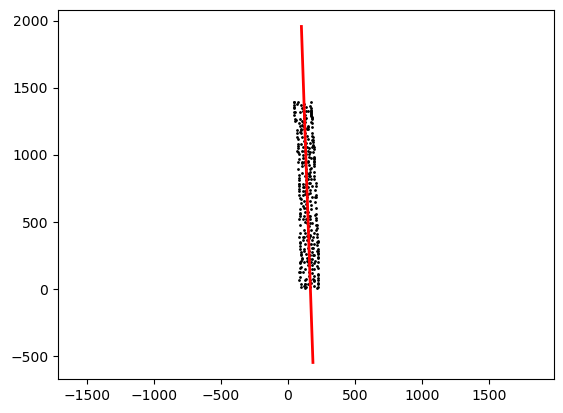

In [210]:
plt.figure()
plt.scatter(all_centroids_array[:,0], all_centroids_array[:,1], color='black', s=1)

# Plot principal axis
line_points = np.array([mean - 3*principal_vector*np.sqrt(eigvals.max()), 
                        mean + 3*principal_vector*np.sqrt(eigvals.max())])
plt.axis('equal')
plt.plot(line_points[:,0], line_points[:,1], 'r-', linewidth=2, label='Principal axis')

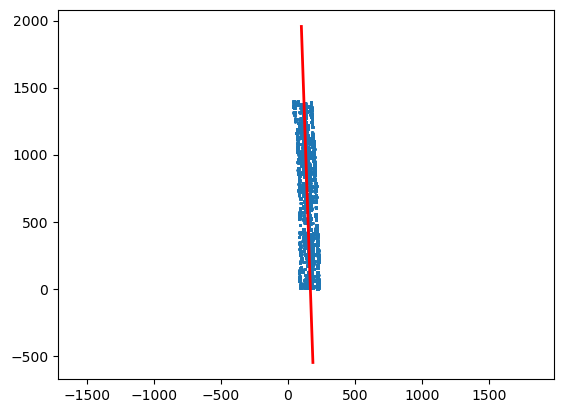

In [223]:

plt.figure()

arr = np.array(cleaned)
y_coords, x_coords = np.where(arr == 0)  # y = row, x = column
plt.scatter(x_coords,y_coords,s=1)
# Plot principal axis
line_points = np.array([mean - 3*principal_vector*np.sqrt(eigvals.max()), 
                        mean + 3*principal_vector*np.sqrt(eigvals.max())])
plt.axis('equal')
plt.plot(line_points[:,0], line_points[:,1], 'r-', linewidth=2, label='Principal axis')

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255

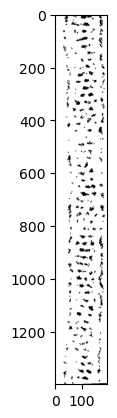

In [ ]:
from scipy.ndimage import rotate
rotated_arr = rotate(arr, 1.9665, reshape=False, order=0)
plt.imshow(rotated_arr[:,30:228],cmap="gray")


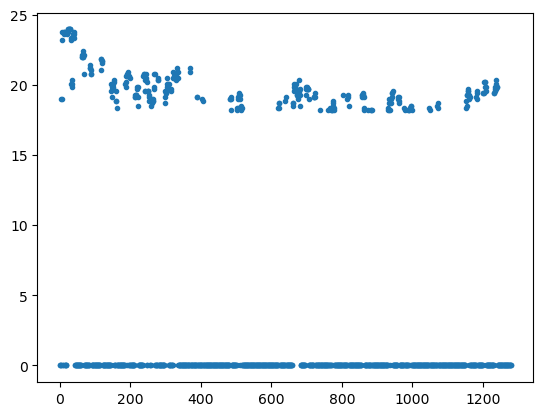

In [275]:
img_ver = rotated_arr[:,30:228]
first_zero_list = []
last_zero_list = []
for arr in img_ver:
    zero_indices = np.where(arr == 0)[0]

    if zero_indices.size > 0:
        first_zero = zero_indices[0]
        last_zero = zero_indices[-1]
        first_zero_list.append(first_zero)
        last_zero_list.append(last_zero)
diff_list = []
for i in range(len(first_zero_list)):
    diff = int(last_zero_list[i] - first_zero_list[i])
    if diff > 120 and diff < 160:
        diff_list.append(diff)
    else:
        diff_list.append(0)
diff_nm = np.array(diff_list) * pixel_to_nm
plt.plot(diff_nm,'o',ms=3)
